При подготовке ноутбука использовались материалы:
1. [LDA topic modelling lenta Kaggle](https://www.kaggle.com/genyagree/lda-topic-modelling/notebook)
2. [LDA topic modelling visualization](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
3. [LDA topic modelling](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

# Введение
**Latent Dirichlet Allocation** (LDA) - статистическая модель, позволяющая разделить набор текстов на $N$ подгрупп.

Каждый кластер характеризуется набором из $X$ ключевых слов. Эти ключевые слова ассоциируются с темой (topic). 

Каждый документ может быть представлен абором тем, каждая тема может быть представлена набором ключевых слов.

### Пример
У нас есть 3 документа:<br>
<br>
D1 = "Собаки любят играть"<br>
D2 = "Кошки любят молоко"<br>
D3 = "Кошки и собаки любят кушать и играть. Я люблю собак. Они милые"<br>

Topic Modelling может выдать следующую модель:<br>
<br>
D1 = 100% Topic1 + 0% Topic2<br>
D2 = 0% Topic1 + 100% Topic2<br>
D3 = 70% Topic1 + 30% Topic2<br>
<br>
Где каждая тема сформирована из слов (в порядке убывания значимости):<br>
<br>
Topic1 = 30% собака, 30% играть, 20% нравиться 10% милая 10% любить<br>
Topic2 = 50% кошка, 30% молоко, 20% нравиться<br>



# Зачем нужно LDA Topic Modeling

Общая задача тематического моделирования - обнаружение скрытой структуры в наборе текстовых данных. 
Для маленького количества текстов мы могли бы использовать просто tf-idf информацию, но для большого числа документов этого уже не достаточно

Практические применения:

1. [Суммаризация мнений](https://dl.acm.org/doi/10.1145/1076034.1076161)
Управляющим организациям, чьи решения влияют на большие группы людей может быть полезно суммаризовать информацию с выражением мнений из открытых источников (постов и комментариев в соцсетях)

2. [Bioinformatics](https://springerplus.springeropen.com/articles/10.1186/s40064-016-3252-8)
Применение метода к "microarray datasets" - датасетам с последовательностями аминокилот или нуклеотидов - для выявления сткрытой структуры этих данных.

3. [Отслеживание трендов в тематиках корпусов текстов](https://timreview.ca/article/1170)
Анализ корпуса текстов - научных публикаций на определенную тему - позволяет отследить, как меняется взгляд на ту или иную научную проблему

4. [Рекомендательные системы](https://habr.com/ru/company/surfingbird/blog/150607/)
Если представить пользователя как набор описания продуктов, которые ему понравились, то можно находить тематики, интересующие пользователя и делать рекомендации в соответствии с ними.



   
# Немного теории
В latent diriclet allocaton (LDA) модели каждый документ в корпусе представляется в виде набора тем в соответствии с распределением Дирихле.

##  Постановка проблемы
- Коллекция документов $D$
- Каждый документ $d$ из коллекции представлен набором слов $W_{d} = (w_{1}, ..., w_{n_{d}})$ из словаря $W$, где $n_{d}$ - длина документа $d$
- Каждому документу соответствует набор тем
- Порядком слов в документе пренебрегают: каждый документ рассматривается как bag-of-words
- Каждая тема $t\in T$ (где $T$ - набор тем) описывается распределением Дирихле $p(w|t)$ на наборе слов $w\in W$, то есть тема представлена в виде вектора $\phi_{t} = (p(w|t):w \in W)$
- Каждый документ $d\in D$ описывается распределением Дирихле $p(t|d)$ на наборе тем $t\in T$. То есть документ описывается вектором $\theta_{d} = (p(t|d):t \in T)$
<br>

![](https://editor.analyticsvidhya.com/uploads/26864dtm.JPG)

Вероятность "возникновения" пары "документ-слово" можно записать следующим образом:

$$
p(w|d)=\sum\limits_{t\in T}p(w|t)p(t|d)
$$

![](https://miro.medium.com/max/780/1*QiTvyHNwvGI5UCqeKvhNsg.png)

## Решение
Построить модель тематического моделирования значит найти матрицы $\Phi = ||p(w|t)||$ и $\Theta = ||p(t|d)||$ на основе коллекции документов $D$.


Для нахождения решения нужно ршеить оптимизационную задачу - максимизировать следующую функцию (максимизируем likelihood наших данных с такими матрицами): 
$$
\sum\limits_{d\in D}\sum\limits_{w\in d}n_{dw}logp(w|d)\to\max\limits_{\Phi,\Theta},
$$
где $n_{dw}$ - частота слова $w$ в документе $d$.

In [2]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
%matplotlib inline
import nltk
import pymorphy2
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ov4t\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ov4t\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Загрузка данных

In [3]:
DATA_DIR = "data"
DATA_FILE = "lenta-ru-news.csv"

In [4]:
rus_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE)).dropna()

D:\soft\anaconda\envs\topic_modelling_2\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
rus_data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [6]:
rus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [7]:
rus_data['topic'].value_counts()

Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64

## Чистка данных

In [8]:
def clean_data(df):
    rusdata_df = df[
        (df['topic'] != 'Библиотека')
      & (df['topic'] != 'Бывший СССР')
      & (df['topic'] != '69-я параллель')
    ].reset_index(drop=True).sample(10000, random_state=42)
    rusdata = rusdata_df['text']
    return rusdata_df, rusdata

In [9]:
rusdata_df, rusdata = clean_data(rus_data)

In [10]:
rusdata

47040     На одном из заводов в городе Салфит на Западно...
47827     Госсекретарь США Колин Пауэлл вновь встретился...
437317    МТС предложила сократить срок эмбарго на строи...
155505    Экс-чемпион мира по боксу Константин Цзю посту...
580672    Народный художник России, кинодекоратор Алекса...
                                ...                        
389799    Руководство американской газеты USA Today попр...
295325    Папу Римского Бенедикта XVI толкнула паломница...
152201    Михаил Фрадков назначил нового заместителя рук...
518313    Посетитель кладбища в районе Вены Хернальс Ман...
270969    В Санкт-Петербурге умер народный артист России...
Name: text, Length: 10000, dtype: object

# Обработка данных

1. Удаление стоп-слов
2. Токенизация
2. Лемматизация
3. Построение словаря n-грамм
4. Tf-idf кодирование

 ## Удаление стоп-слов

1. Стоп-слова из библиотеки nltk
2. Дополнительный набор стоп-слов №1 ([github](https://github.com/stopwords-iso/stopwords-ru))
3. Дополнительный набор стоп-слов №2 ([github](https://github.com/Alir3z4/stop-words))

In [11]:
STOPWORDS_DIR = "stopwords"

In [12]:
def get_stop_words():
    stopwordsrus = list(stopwords.words('russian'))
    with open(os.path.join(STOPWORDS_DIR, "russian.txt")) as f:
        stop_words_1 = f.read().split("\n")
    with open(os.path.join(STOPWORDS_DIR, "stopwords-ru.txt")) as f:
        stop_words_2 = f.read().split("\n")
    return set(stopwordsrus + stop_words_1 + stop_words_2)

In [13]:
stopwordsru = get_stop_words()

### Токенизация

In [14]:
def tokenize_text(text):
    return list(t.lower() for t in word_tokenize(text) if t.isalpha())


def delete_stop_words(text):
    return [w for w in text if w not in stopwordsru]

In [15]:
data = [tokenize_text(t) for t in rusdata]

## Лемматизация

In [16]:
morph = pymorphy2.MorphAnalyzer()
def lemmatizer(texts):
    return [[morph.parse(word)[0] for word in text] for text in texts]

In [17]:
morph_data = lemmatizer(data)

In [18]:
def extract_lemma(texts):
    norm = []
    for t in texts:
        res = []
        for word in t:
            n = word.normal_form
            res.append(n)
        norm.append(res)
    return norm

In [19]:
# This is our lemmatized data ready to be used further:
data_norm = extract_lemma(morph_data)

In [20]:
# correct deletion of stopwords
data_norm = [delete_stop_words(text) for text in data_norm]

# Визуализация

In [21]:
def wordcloud_visualization(list_of_tokenized_sentences):
    # Join the different processed titles together.
    long_string = ','.join([','.join(x) for x in list_of_tokenized_sentences])

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

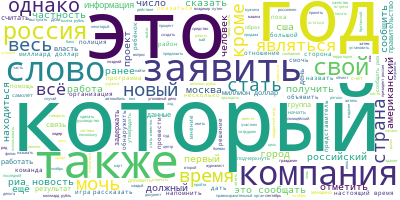

In [22]:
wordcloud_visualization(data_norm)

## Построение n-грамм

*Смотри документацию [Phrases](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) и [Phraser](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.FrozenPhrases). Phraser ускоряет работу Phrases*

In [23]:
bigram = gensim.models.Phrases(data_norm, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_norm], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [24]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_trigrams = make_trigrams(data_norm)

In [25]:
print(data_words_trigrams[0])

['завод', 'город', 'салфита', 'западный_берег', 'израильский', 'военный', 'обнаружить', 'называть', 'пояс_шахид', 'предназначить', 'совершение_теракт', 'посредством', 'самоубийство', 'сообщать', 'издание', 'сведение', 'израильский', 'спецслужба', 'исламский', 'экстремист', 'подготовить', 'около', 'сто', 'который', 'планироваться', 'направить', 'иерусалим', 'данные', 'ряд', 'источник', 'финансировать', 'подобный', 'процесс', 'подготовка', 'теракт', 'мочь', 'структура', 'базироваться', 'саудовский_аравия', 'агентство', 'выяснить', 'накануне', 'саудовский_аравия', 'счёт', 'семья', 'самоубийца', 'джамаль', 'нассера', 'поступить', 'тысяча', 'доллар', 'именно', 'человек', 'совершить', 'теракт', 'район', 'наблус', 'врезаться', 'автобус', 'машина', 'загрузить', 'взывчатка', 'подобный', 'платёж', 'семья', 'погибнуть', 'палестинский', 'террорист', 'регулярно', 'проходить', 'саудовский_аравия', 'утверждать', 'источник', 'среда', 'министр_внутренний_дело', 'саудовский_аравия', 'найефа', 'бин', 'пр

## Создание словаря n-gram и BOW

*Смотри документацию [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary) и [doc2bow](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow).*

In [26]:
dictionary = corpora.Dictionary(data_words_trigrams)

corpus = [dictionary.doc2bow(doc) for doc in data_words_trigrams]
# We will also try to filter unimportant words by their tf-idf score, so let's create the tf-idf scores here too


In [27]:
dictionary[3]

'базироваться'

## Encoding Tf-Idf

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

[Статья с хорошим описанием](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)

$t$ — term (word)<br>
$d$ — document (set of words)<br>
$D$ - коллекция документов<br>
$N$ — размер коллекции документов $D$<br>


$$tf(t,d) = \frac{n_{td}}{n_{d}}$$
Частота встречаемости слова в документе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$df(t) = \sum_d{n_{td}}$$
Встречаемость слова в корпусе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$idf(t) = log(\frac{N}{df(t)+1})$$
Обратная встречаемость слова в корпусе.<br>
<br>

**$$tfidf(t,d) = tf(t,d)*idf(t)$$**

In [28]:
tfidf = gensim.models.TfidfModel(corpus, id2word = dictionary)

# Построение модели LDA Topic Modelling

## Использование корпуса без TF-IDF фильтрации

In [29]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
pprint(lda_model.show_topics(formatted=False))

[(59,
  [('причаститься', 1.5492584e-05),
   ('подоходный', 1.5492584e-05),
   ('цапп', 1.5492584e-05),
   ('хартмут', 1.5492584e-05),
   ('фрайбург', 1.5492584e-05),
   ('раскаяние', 1.5492584e-05),
   ('будить', 1.5492584e-05),
   ('посреднический', 1.5492584e-05),
   ('загс', 1.5492584e-05),
   ('миропомазание', 1.5492584e-05)]),
 (61,
  [('причаститься', 1.5492584e-05),
   ('подоходный', 1.5492584e-05),
   ('цапп', 1.5492584e-05),
   ('хартмут', 1.5492584e-05),
   ('фрайбург', 1.5492584e-05),
   ('раскаяние', 1.5492584e-05),
   ('будить', 1.5492584e-05),
   ('посреднический', 1.5492584e-05),
   ('загс', 1.5492584e-05),
   ('миропомазание', 1.5492584e-05)]),
 (34,
  [('квартира', 0.39308956),
   ('пятилетний', 0.017887801),
   ('раскаяние', 9.125765e-06),
   ('причаститься', 9.125765e-06),
   ('цапп', 9.125765e-06),
   ('хартмут', 9.125765e-06),
   ('фрайбург', 9.125765e-06),
   ('будить', 9.125765e-06),
   ('отлучать', 9.125765e-06),
   ('миропомазание', 9.125765e-06)]),
 (71,
  [(

In [31]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=rusdata.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,78,11,0.2108,0.1587,"операция, теракт, соглашение, оон, суббота, те...","год, который, это, сообщать, также, свой, врем...",На одном из заводов в городе Салфит на Западно...
1,11,68,0.1794,0.1317,"год, который, это, сообщать, также, свой, врем...","страна, власть, представитель, число, территор...",Госсекретарь США Колин Пауэлл вновь встретился...
2,11,33,0.1602,0.1429,"год, который, это, сообщать, также, свой, врем...","письмо, получение, услуга, сокращение, операто...",МТС предложила сократить срок эмбарго на строи...
3,11,45,0.1551,0.1005,"год, который, это, сообщать, также, свой, врем...","россия, заявить, российский, слово, мочь, глав...",Экс-чемпион мира по боксу Константин Цзю посту...
4,44,11,0.2862,0.1314,"роман, центральный, старый, институт, наиболее...","год, который, это, сообщать, также, свой, врем...","Народный художник России, кинодекоратор Алекса..."
5,25,11,0.2953,0.1705,"счёт, минута, победа, матч, чемпионат, турнир,...","год, который, это, сообщать, также, свой, врем...","Мадридский ""Реал"" обеспечил себе победу в чемп..."
6,72,11,0.2609,0.1568,"сша, американский, военный, ирак, угроза, амер...","год, который, это, сообщать, также, свой, врем...",Бюджетный комитет федерального парламента Герм...
7,64,11,0.2868,0.1793,"автомобиль, производство, машина, завод, модел...","год, который, это, сообщать, также, свой, врем...",Продажи нового бюджетного седана Nissan Almera...
8,11,74,0.166,0.1544,"год, который, это, сообщать, также, свой, врем...","человек, задержать, сотрудник, дом, данные, уб...","Двое американцев, занимавшихся мошенничеством ..."
9,11,45,0.1388,0.1271,"год, который, это, сообщать, также, свой, врем...","россия, заявить, российский, слово, мочь, глав...",Более четверти бывших министров администрации ...


In [32]:
df_dominant_topic.loc[2]["text"]

'МТС предложила сократить срок эмбарго на строительство сетей стандарта связи LTE в Краснодарском крае для тех операторов, которые не являются партнерами Олимпийских игр в Сочи, пишет «Коммерсантъ». Эмбарго предлагается отменить в конце 2014 года, тогда как сейчас оно действует до декабря 2016 года. МТС направила соответствующее письмо в Минсвязи. Компания отмечает, что является лидером по количеству абонентов в крае и ограничение на строительство новых сетей рассматривает как несправедливое. Как передает издание, 2 июля комиссия по радиочастотам (ГКРЧ) может рассмотреть сокращение срока эмбарго, но решение будет отрицательным, поскольку против этого выступил Роскомнадзор. Кроме того, решение установлено федеральным законом, так что у ГКРЧ может не оказаться полномочий, чтобы его отменить. Услуги в ходе Олимпиады могут оказывать «МегаФон» и «Ростелеком», являющиеся ее генеральными партнерами. В других же компаниях решение об эмбарго до конца 2016 года считают «технической ошибкой», пос

In [33]:
df_dominant_topic.loc[2]["Topic_Keywords1"]

'год, который, это, сообщать, также, свой, время, стать, первый, однако'

In [34]:
df_dominant_topic.to_csv('./results/dominant_topic_no_tfidf_limit.csv', index=False)

## Визуализация

In [35]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_no_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_news_no_tfidf_limits' +'.html')
LDAvis_prepared

D:\soft\anaconda\envs\topic_modelling_2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.293905 -0.141914       1        1  19.929496
45    -0.282412 -0.138090       2        1  10.891369
68    -0.235861 -0.186429       3        1   5.069585
62    -0.215229  0.032863       4        1   4.775019
56    -0.223462  0.011104       5        1   4.457462
...         ...       ...     ...      ...        ...
8      0.179959 -0.040432      76        1   0.090725
34     0.188789 -0.040779      77        1   0.066168
71     0.201588 -0.040750      78        1   0.062705
59     0.229532 -0.038413      79        1   0.003450
61     0.229532 -0.038413      80        1   0.003437

[80 rows x 5 columns], topic_info=                Term          Freq         Total Category  logprob  loglift
179              год  26119.000000  26119.000000  Default  30.0000  30.0000
39           который  17878.000000  17878.000000  Default  29.0000  29.0000
195         компания   5614.000000   5614.000000  Default  28.0000  28.0000
1237         процент   4815.000000   4815.000000  Default  27.0000  27.0000
116              это  16835.000000  16835.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
25             завод      0.000622    468.672159  Topic80 -11.0751  -3.2537
26         загрузить      0.000622     39.487234  Topic80 -11.0751  -0.7798
27        заниматься      0.000622   1080.648102  Topic80 -11.0751  -4.0891
28    западный_берег      0.000622     27.516729  Topic80 -11.0751  -0.4186
29          заявлять      0.000622    384.880420  Topic80 -11.0751  -3.0567

[2989 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4431     40  0.986916         a
3074      3  0.995683       afp
426      17  0.995643    agence
1293     46  0.975964       air
4180     48  0.971323       all
...     ...       ...       ...
276       1  0.999682  являться
3144     10  0.995525   ядерный
844       2  0.999400    январь
644       3  0.996645    япония
904      41  0.997279  японский

[2319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 46, 69, 63, 57, 75, 16, 6, 50, 73, 39, 47, 13, 30, 23, 78, 79, 8, 20, 52, 71, 22, 58, 37, 25, 51, 80, 7, 49, 26, 38, 65, 18, 64, 3, 43, 15, 17, 41, 5, 68, 36, 45, 19, 1, 77, 24, 28, 2, 61, 42, 40, 27, 55, 34, 44, 74, 54, 56, 33, 29, 11, 76, 31, 48, 32, 59, 67, 70, 21, 4, 66, 10, 53, 14, 9, 35, 72, 60, 62])

# Оценка качества

### Perplexity

[Подробное описание](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)


Оценка генеративной языковой модели.

Мы хотим, чтобы наша языковая модель приписывала высокие вероятности реальным предложениям и низкие - нереальным. Поэтому чем ниже PP, тем лучше.


$PP(W)$ - обратная вероятность тестового корпуса слов, нормированная на его размер

$$PP(W) = \frac1{P(w_1,...,w_N)^{\frac1N}}$$


In [36]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.


Perplexity:  -36.221149044229286


# Задание

## Использование корпуса c TF-IDF фильтрацией (10 баллов)

TFIDF коэффициенты выделяют слова, которые являются часто употребимыми (не несут информации о конкретном документе) или те, которые встречаются только в одном документе и не могут показать скрытую связь между документами. 

В этом задании нужно
1. Найти максимальное и минимальное значение tfidf скора

*Подсказка*: нужно проитерироваться по всему корпусу слов, посчитать tfidf скор и найти пороговые значения

2. Построить дискретный массив tfidf скоров с шагом 0.005 и найти перцентили 10 и 95

3. Отфильтровать corpus в filtered_corpus, оставив только слова со скорами, попадающими в диапазон от 10 до 95 перцентилей.
4. Построить подель LDA на отфильтрованном корпусе
5. Посчитать метрики качества
5. Сделать визуализацию тематик
6. Посмотреть на темы с наибольшими коэффициентами в датафрейме
7. Напишите, какой вывод можно сделать

**Комментарий** - можно уменьшать количество  $n_{\text{topics}}$, если вашему компьютеру не хватает вычислительных мощностей.

**Комментарий** - если при визуализации вы получили ошибку `TypeError: Object of type complex is not JSON serializable`, добавьте в метод `prepare` аргумент `mds='mmds'`

Задание выполнил студент CSC Овчаренко Анатолий

### Подсчет граничных перцентилей `tf-idf`

In [37]:
tfidf_max = -1
tfidf_min = float("+inf")

for text in corpus:
    tfidfs_scores = tfidf[text]
    tfidf_max = max(tfidf_max, max(p[1] for p in tfidfs_scores))
    tfidf_min = min(tfidf_min, min(p[1] for p in tfidfs_scores))

tfidf_min, tfidf_max

(0.001557987607442177, 1.0)

In [38]:
tfidf_descrete_arr = np.arange(tfidf_min, tfidf_max, 5e-3)

tfidf_10perc = np.percentile(tfidf_descrete_arr, 10)
tfidf_95perc = np.percentile(tfidf_descrete_arr, 95)

tfidf_10perc, tfidf_95perc

(0.1010579876074422, 0.9468079876074421)

### Фильтрация корпуса

In [39]:
filtered_corpus = []
for text in corpus:
    tfidf_scores = tfidf[text]
    filtered_text = []
    for w, p in zip(text, tfidf_scores):
        if tfidf_10perc <= p[1] <= tfidf_95perc:
            filtered_text.append(w)
    filtered_corpus.append(filtered_text)

### Построение LDA на основе отфильтрованного корпуса

In [40]:
filtered_lda_model = gensim.models.ldamodel.LdaModel(
    corpus=filtered_corpus,
    id2word=dictionary,
    num_topics=50, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha="auto",
    per_word_topics=True)

In [41]:
pprint(filtered_lda_model.show_topics(formatted=False))

[(36,
  [('причаститься', 1.5492587e-05),
   ('подоходный', 1.5492587e-05),
   ('цапп', 1.5492587e-05),
   ('хартмут', 1.5492587e-05),
   ('фрайбург', 1.5492587e-05),
   ('раскаяние', 1.5492587e-05),
   ('будить', 1.5492587e-05),
   ('посреднический', 1.5492587e-05),
   ('загс', 1.5492587e-05),
   ('миропомазание', 1.5492587e-05)]),
 (25,
  [('заложник', 0.06299974),
   ('раскаяние', 1.4516784e-05),
   ('посреднический', 1.4516784e-05),
   ('батлер', 1.4516784e-05),
   ('цапп', 1.4516784e-05),
   ('хартмут', 1.4516784e-05),
   ('фрайбург', 1.4516784e-05),
   ('гмозёры', 1.4516784e-05),
   ('причаститься', 1.4516784e-05),
   ('исповедаться', 1.4516784e-05)]),
 (10,
  [('вирус', 0.07421925),
   ('геном', 0.017343968),
   ('гигантский', 0.005411694),
   ('элемент', 0.0042297407),
   ('фрайбург', 1.3925528e-05),
   ('батлер', 1.3925528e-05),
   ('цапп', 1.3925528e-05),
   ('хартмут', 1.3925528e-05),
   ('гмозёры', 1.3925528e-05),
   ('посреднический', 1.3925528e-05)]),
 (5,
  [('землетрясе

In [47]:
filtered_df_topic_sents_keywords = format_topics_sentences(ldamodel=filtered_lda_model, corpus=filtered_corpus, texts=rusdata.values)

filtered_df_dominant_topic = filtered_df_topic_sents_keywords \
                               .sort_values(by=["%Topic_Contribution1", "%Topic_Contribution2"], ascending=False) \
                               .reset_index(drop=True)
filtered_df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,8,NaN,0.9691,NaN,"цена, мвд, ведомство, оборудование, сенатор, к...",NaN,Председатель правления Пенсионного фонда Росси...
1,19,NaN,0.9653,NaN,"рубль, доллар, страна, евро, курс, торг, валют...",NaN,Курс рубля утром 8 июля продолжил свое падение...
2,7,NaN,0.9649,NaN,"президент, самолёт, путин, лидер, трамп, объек...",NaN,Претендент на пост президента США от республик...
3,17,NaN,0.9629,NaN,"спортсмен, группировка, деятельность, министр,...",NaN,Хакерская группировка Fancy Bear опубликовала ...
4,19,NaN,0.9589,NaN,"рубль, доллар, страна, евро, курс, торг, валют...",NaN,Центробанк опустил официальный курс доллара ни...
5,20,NaN,0.9577,NaN,"банк, объём, кредит, рабочий, долг, передать, ...",NaN,"Банк ""Ренессанс капитал"" выставил на продажу п..."
6,19,NaN,0.9573,NaN,"рубль, доллар, страна, евро, курс, торг, валют...",NaN,Средневзвешенный курс доллара утром 15 апреля ...
7,19,NaN,0.9573,NaN,"рубль, доллар, страна, евро, курс, торг, валют...",NaN,Торги на российском валютном рынке ММВБ 4 октя...
8,10,NaN,0.957,NaN,"вирус, геном, гигантский, элемент, фрайбург, б...",NaN,Ученые обнаружили новый вид гигантских вирусов...
9,22,NaN,0.9541,NaN,"автомобиль, завод, машина, нападение, альянс, ...",NaN,Продажи нового бюджетного седана Nissan Almera...


### Значение логарифма перплексии для новой модели

In [48]:
print("\nPerplexity (filtered corpus): ", filtered_lda_model.log_perplexity(filtered_corpus)) 


Perplexity (filtered corpus):  -51.60674068845905


### Сохранение результатов и отрисовка визуализации

In [44]:
filtered_df_dominant_topic.to_csv("./results/dominant_topic_tfidf_limit.csv", index=False)

In [45]:
LDAvis_data_filepath = os.path.join("./results/ldavis_prepared_news_tfidf_limits")

LDAvis_prepared = gensimvis.prepare(filtered_lda_model, filtered_corpus, dictionary, mds="mmds")
with open(LDAvis_data_filepath, "wb") as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, "./results/ldavis_prepared_news_tfidf_limits" + ".html")
LDAvis_prepared

D:\soft\anaconda\envs\topic_modelling_2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.323124  0.256606       1        1  5.237877
13    -0.133106 -0.382424       2        1  4.402930
1     -0.234723 -0.217435       3        1  4.187320
7      0.379135  0.021753       4        1  4.053687
26     0.026403  0.315969       5        1  3.662932
28     0.301268 -0.120816       6        1  3.540231
4      0.204811 -0.253352       7        1  3.455746
43    -0.354807  0.065419       8        1  3.444204
40    -0.294030 -0.130707       9        1  3.334110
2      0.128149  0.295353      10        1  3.130701
45     0.187057  0.225663      11        1  2.958781
41    -0.189059  0.229602      12        1  2.857317
39    -0.103825  0.275485      13        1  2.788579
24     0.111144 -0.253750      14        1  2.573312
32     0.259287  0.119455      15        1  2.484416
0     -0.150725 -0.174828      16        1  2.483236
47     0.013316 -0.273990      17        1  2.413155
12    -0.230145 -0.050905      18        1  2.310161
29    -0.128165 -0.107156      19        1  2.219512
46    -0.225810  0.077867      20        1  2.197679
44     0.177309 -0.155583      21        1  2.168284
20    -0.018732 -0.214424      22        1  2.083126
38     0.213557 -0.056779      23        1  2.067939
34     0.055386 -0.186394      24        1  2.000616
37    -0.179370  0.001675      25        1  1.967361
15    -0.010847  0.223836      26        1  1.897383
8      0.175009  0.114148      27        1  1.729493
3      0.130794 -0.107498      28        1  1.709817
14     0.141730  0.048445      29        1  1.701189
23     0.193241  0.002636      30        1  1.610466
42    -0.076656 -0.186563      31        1  1.564764
22    -0.121701  0.112945      32        1  1.497114
49     0.066583  0.131147      33        1  1.461081
17    -0.106161  0.039887      34        1  1.373400
9     -0.090331 -0.026072      35        1  1.291523
48     0.101146  0.087745      36        1  1.218171
21    -0.023298  0.156003      37        1  1.187097
27    -0.041058  0.074988      38        1  1.151776
18     0.077697 -0.006612      39        1  1.010575
31     0.032163  0.066043      40        1  1.002075
33    -0.017103  0.068583      41        1  0.926161
35     0.024543 -0.055435      42        1  0.837799
11    -0.010233 -0.039356      43        1  0.560631
6      0.029566 -0.005599      44        1  0.545578
30     0.003649  0.017989      45        1  0.420514
16    -0.002583 -0.010637      46        1  0.406059
5      0.016317 -0.007639      47        1  0.302455
10     0.007048 -0.008166      48        1  0.284276
25     0.001124  0.001692      49        1  0.205547
36     0.008162  0.001185      50        1  0.081841, topic_info=                Term         Freq        Total Category  logprob  loglift
1237         процент  7759.000000  7759.000000  Default  30.0000  30.0000
105              сша  3752.000000  3752.000000  Default  29.0000  29.0000
634            рубль  3687.000000  3687.000000  Default  28.0000  28.0000
195         компания  2904.000000  2904.000000  Default  27.0000  27.0000
460             матч  3224.000000  3224.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
20            деньга     0.005042   548.497802  Topic50 -11.0751  -4.4889
22            доллар     0.005042  2878.577340  Topic50 -11.0751  -6.1468
23            житель     0.005042   321.776991  Topic50 -11.0751  -3.9556
25             завод     0.005042   632.189848  Topic50 -11.0751  -4.6309
28    западный_берег     0.005042    44.506994  Topic50 -11.0751  -1.9774

[1754 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4431      7  0.969273            a
4508     11  0.828649          bmw
1295      4  0.966176       boeing
2633     15  0.954125         dead
4438      7  0.970852        games
...     ...       ...         

### Выводы
Итак, хорошо видно, что фильтрация корпуса с помощью TF-IDF привела к значительному росту качества модели:
1. Ключевая исследуемая здесь метрика логарифма перплексии заметно уменьшилась;
2. Темы, которые извлекла модель, стали более осмысленными (см. визуализацию выше или в файле `./results/ldavis_prepared_news_tfidf_limits.html`:)
    * Тема 1 непосредственно связана с экономикой и валютами (евро, рубль, доллар, курс, ...);
    * Тема 4 существенно связана с политикой, а именно с политическими лидерами государств (президент, путин, трамп, ...);
    * Тема 22 связана с банковской сферой (банк, объем, кредит, сбербанк, ...);
    * ...

## Дополнительное задание (2 балла)

Постройте LDA Topic modelling модель для [датасета постов о политике с Пикабу](https://www.kaggle.com/atomin/pikabu-politic-posts). 

При построении можете поизменять параметры `alpha` и `beta` для получения более качественной модели.

Какие выводы можно сделать на основе полученной модели?

In [ ]:

tf_max = #YOUR_CODE
tf_min = #YOUR_CODE
print(tf_max, tf_min)
tfidf_range = #YOUR_CODE

print(np.percentile(tfidf_range, 95), np.percentile(tfidf_range, 10))

In [38]:
low_value = np.percentile(tfidf_range, 10) 
high_value = np.percentile(tfidf_range, 95) 

filtered_corpus = []
for i in range(0, len(corpus)):
        
    filter_ids = #YOUR_CODE
   
    new_bow = #YOUR_CODE
      
    filtered_corpus.append(new_bow)

In [82]:
lda_model_tfidf = #YOUR_CODE

In [83]:
# Show Topics
pprint(lda_model_tfidf.show_topics(formatted=False))

[(34,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (44,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (13,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (52,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802

In [86]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_with_tfidf')

LDAvis_prepared = #YOUR_CODE
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_with_no_tfidf' +'.html')
LDAvis_prepared

C:\ProgramData\Anaconda3\envs\topic_modelling_2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
41     0.427692  0.033073       1        1  3.315873
5      0.183917  0.309363       2        1  3.124598
22     0.325356  0.270014       3        1  3.114157
1     -0.367516 -0.063728       4        1  2.701882
73     0.223593 -0.273546       5        1  2.673219
...         ...       ...     ...      ...       ...
39    -0.006156 -0.000034      76        1  0.074927
44    -0.006157 -0.000034      77        1  0.074724
56    -0.006156 -0.000034      78        1  0.074724
34    -0.006156 -0.000033      79        1  0.074724
57    -0.006155 -0.000033      80        1  0.074724

[80 rows x 5 columns], topic_info=                Term         Freq        Total Category  logprob  loglift
1241         процент  7802.000000  7802.000000  Default  30.0000  30.0000
105              сша  3780.000000  3780.000000  Default  29.0000  29.0000
420            фильм  3243.000000  3243.000000  Default  28.0000  28.0000
196         компания  3166.000000  3166.000000  Default  27.0000  27.0000
1184         украина  3134.000000  3134.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
21            доллар     0.004568  2323.281522  Topic80 -11.0762  -5.9402
22            житель     0.004568   282.399070  Topic80 -11.0762  -3.8328
24             завод     0.004568  1095.923466  Topic80 -11.0762  -5.1888
27    западный_берег     0.004568    45.708513  Topic80 -11.0762  -2.0118
29         иерусалим     0.004568   264.539310  Topic80 -11.0762  -3.7675

[2901 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4446     67  0.915896            a
649      21  0.297061          aol
1515      5  0.985309     bbc_news
4523     15  0.791765          bmw
1300     11  0.967785       boeing
...     ...       ...          ...
3742      2  0.941114        юноша
3545     27  0.963340         юрий
3875     59  0.783533   юрисдикция
1882     48  0.963344        юрист
118      25  0.945216  ясир_арафат

[724 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[42, 6, 23, 2, 74, 44, 69, 13, 79, 4, 71, 78, 48, 47, 24, 31, 66, 19, 15, 65, 27, 68, 25, 60, 54, 67, 18, 26, 11, 37, 64, 50, 76, 72, 63, 10, 12, 51, 73, 36, 43, 46, 41, 28, 75, 8, 5, 16, 21, 59, 62, 49, 33, 1, 34, 70, 20, 32, 29, 30, 55, 56, 17, 77, 52, 38, 9, 80, 7, 22, 61, 3, 39, 53, 14, 40, 45, 57, 35, 58])

In [ ]:
print('\nPerplexity: ', #YOUR_CODE)  

In [ ]:
df_topic_sents_keywords = #YOUR_CODE


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

In [92]:
df_dominant_topic.to_csv('./results/dominant_topic_with_tfidf_limit.csv', index= False)

In [ ]:
df_dominant_topic.loc[2]["text"]

In [ ]:
df_dominant_topic.loc[2]["Topic_Keywords2"]